In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_theme(style="whitegrid")
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras import layers
import statsmodels.api as sm

import kerastuner
from scipy.fft import rfft, rfftfreq

SEED = 1
tf.random.set_seed(SEED)   # set random seed for reproducibility

BASE_PATH = r"C:\Users\Daniel\Documents\Studium\8. Semester (SS 2021)\Data Mining and Applications\Project\Data"
features_train = pd.read_csv(BASE_PATH + "/dengue_features_train.csv")
labels_train = pd.read_csv(BASE_PATH + "/dengue_labels_train.csv")
features_test = pd.read_csv(BASE_PATH + "/dengue_features_test.csv")

print("Dependencies and data imported.")

Dependencies and data imported.


This notebook follows the [CRISP-DM](https://en.wikipedia.org/wiki/Cross-industry_standard_process_for_data_mining) approach for data science projects.

# 1) Business Understanding
- DengAI is part of a [DrivenData competition](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/page/80/)
- Goal: **Predict weekly dengue fever cases in Iquitos (Peru) and San Juan (Puerto Rico) based on climatology data**
- From the description:
    - Dengue fever is a mosquito-borne disease that occurs in tropical and sub-tropical parts of the world. In mild cases, symptoms are similar to the flu: fever, rash, and muscle and joint pain. In severe cases, dengue fever can cause severe bleeding, low blood pressure, and even death.
    - Because it is carried by mosquitoes, the transmission dynamics of dengue are related to climate variables such as temperature and precipitation.
    - These days many of the nearly half billion cases per year are occurring in Latin America.

# 2) Data Understanding
### Data sources
- Included measurements
    - NOAA's GHCN daily climate data weather station measurements
    - PERSIANN satellite precipitation measurements (0.25x0.25 degree scale)
    - NOAA's NCEP Climate Forecast System Reanalysis measurements (0.5x0.5 degree scale)
    - Satellite vegetation - Normalized difference vegetation index (NDVI) - NOAA's CDR Normalized Difference Vegetation Index (0.5x0.5 degree scale) measurements
- For detailed feature descriptions see [here](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/page/82/).

In [83]:
features_train.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [86]:
features_train.columns

Index(['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm'],
      dtype='object')

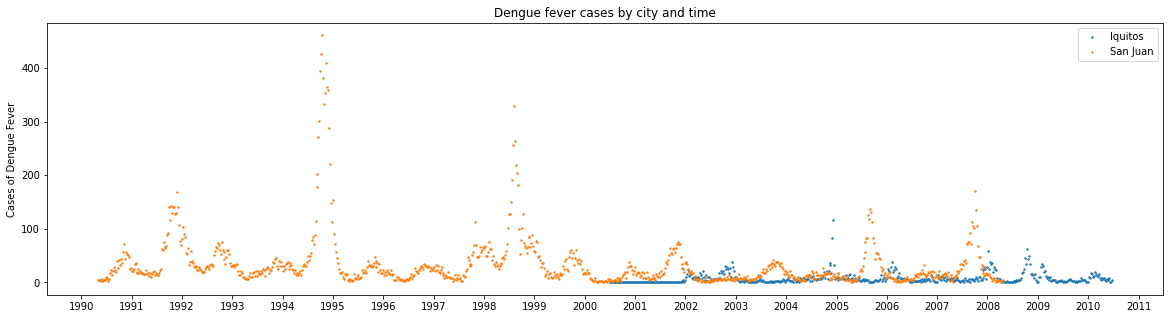

In [78]:
# Use subsets of data (one for each city)
X_iquitos = features_train[features_train["city"] == "iq"]
X_san_juan = features_train[features_train["city"] == "sj"]
y_iquitos = labels_train["total_cases"][X_iquitos.index]
y_san_juan = labels_train["total_cases"][X_san_juan.index]

train_datetime_index = pd.to_datetime(features_train["week_start_date"])

fig, ax = plt.subplots()
fig.set_size_inches((20, 5))
ax.scatter(x=train_datetime_index[y_iquitos.index], y=y_iquitos, s=2, label="Iquitos")
ax.scatter(x=train_datetime_index[y_san_juan.index], y=y_san_juan, s=2, label="San Juan")
ax.legend()
ax.set_ylabel("Cases of Dengue Fever")
ax.set_title("Dengue fever cases by city and time")

# Show all years in x axis
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

## Appearing values and value ranges

### Summary statistics

In [108]:
features_train.describe()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
count,1456.000000,1456.000000,1262.000000,1404.000000,1434.000000,1434.000000,1443.000000,1446.000000,1446.000000,1446.000000,...,1446.000000,1446.000000,1443.000000,1446.000000,1446.000000,1413.000000,1413.000000,1436.000000,1442.000000,1434.000000
mean,2001.031593,26.503434,0.142294,0.130553,0.203783,0.202305,45.760388,298.701852,299.225578,295.246356,...,40.151819,82.161959,45.760388,16.746427,4.903754,27.185783,8.059328,32.452437,22.102150,39.326360
std,5.408314,15.019437,0.140531,0.119999,0.073860,0.083903,43.715537,1.362420,1.261715,1.527810,...,43.434399,7.153897,43.715537,1.542494,3.546445,1.292347,2.128568,1.959318,1.574066,47.455314
min,1990.000000,1.000000,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,294.635714,294.892857,289.642857,...,0.000000,57.787143,0.000000,11.715714,1.357143,21.400000,4.528571,26.700000,14.700000,0.000000
25%,1997.000000,13.750000,0.044950,0.049217,0.155087,0.144209,9.800000,297.658929,298.257143,294.118929,...,13.055000,77.177143,9.800000,15.557143,2.328571,26.300000,6.514286,31.100000,21.100000,8.700000
50%,2002.000000,26.500000,0.128817,0.121429,0.196050,0.189450,38.340000,298.646429,299.289286,295.640714,...,27.245000,80.301429,38.340000,17.087143,2.857143,27.414286,7.300000,32.800000,22.200000,23.850000
75%,2005.000000,39.250000,0.248483,0.216600,0.248846,0.246982,70.235000,299.833571,300.207143,296.460000,...,52.200000,86.357857,70.235000,17.978214,7.625000,28.157143,9.566667,33.900000,23.300000,53.900000
max,2010.000000,53.000000,0.508357,0.454429,0.538314,0.546017,390.600000,302.200000,302.928571,298.450000,...,570.500000,98.610000,390.600000,20.461429,16.028571,30.800000,15.800000,42.200000,25.600000,543.300000


### Violinplots

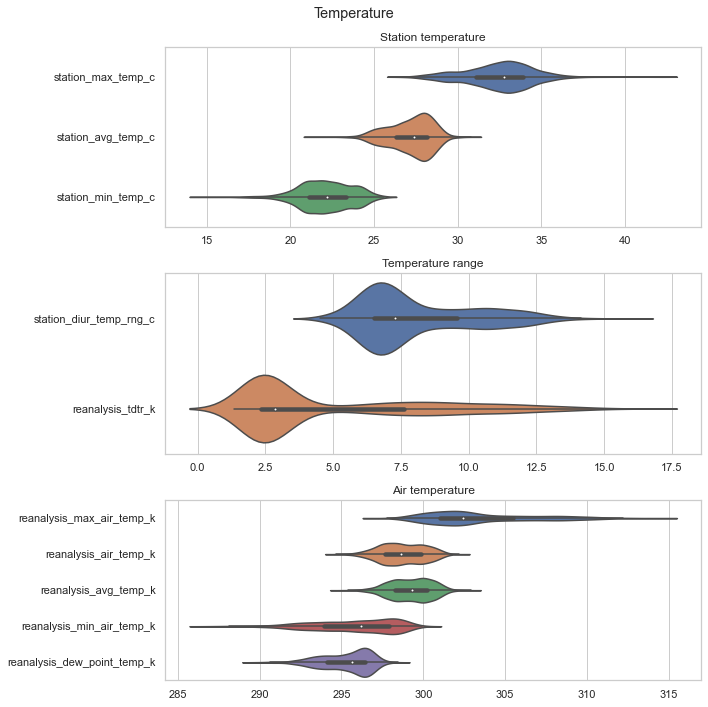

In [41]:
# Temperatures
fig, ax = plt.subplots(3, 1)
plt.suptitle("Temperature")
fig.set_size_inches((10, 10))

temp_plt1 = sns.violinplot(data=features_train[['station_max_temp_c', 'station_avg_temp_c', 'station_min_temp_c']],
                           orient="h", ax=ax[0])
temp_plt1.set_title("Station temperature [°C]")
temp_plt2 = sns.violinplot(data=features_train[['station_diur_temp_rng_c', 'reanalysis_tdtr_k']],
                           orient="h", ax=ax[1])
temp_plt2.set_title("Temperature range [°C]")
temp_plt3 = sns.violinplot(data=features_train[['reanalysis_max_air_temp_k', 'reanalysis_air_temp_k', 'reanalysis_avg_temp_k',
                                                'reanalysis_min_air_temp_k', 'reanalysis_dew_point_temp_k']],
                           orient="h", ax=ax[2])
temp_plt3.set_title("Air temperature")

fig.tight_layout()

Text(0.5, 1.0, 'Precipitation [in mm and kg/m²]')

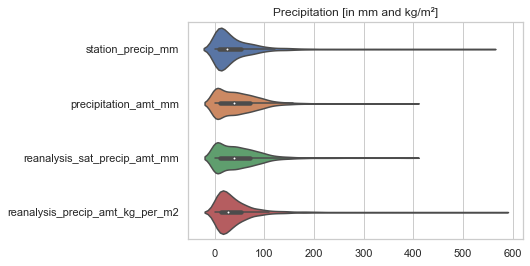

In [40]:
ax = sns.violinplot(data=features_train[['station_precip_mm', 'precipitation_amt_mm',
                               'reanalysis_sat_precip_amt_mm',
                               'reanalysis_precip_amt_kg_per_m2']],
               orient="h")
ax.set_title("Precipitation [in mm and kg/m²]")

Text(0.5, 1.0, 'Humidity [in % and g/kg]')

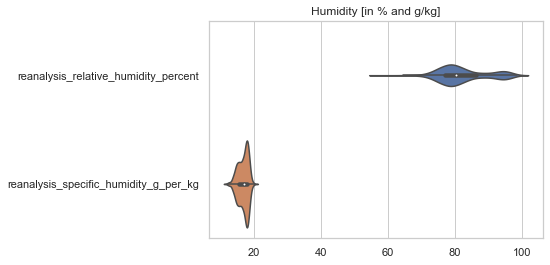

In [42]:
# Humidity
ax = sns.violinplot(data=features_train[['reanalysis_relative_humidity_percent', 'reanalysis_specific_humidity_g_per_kg']],
                    orient="h")
ax.set_title("Humidity [in % and g/kg]")

Text(0.5, 1.0, 'Humidity')

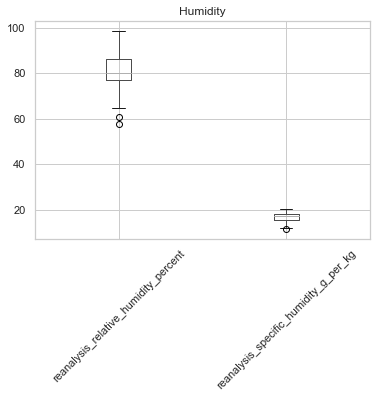

In [43]:
# Boxplot as comparison
fig, ax = plt.subplots()
features_train[['reanalysis_relative_humidity_percent', 'reanalysis_specific_humidity_g_per_kg']].boxplot(rot=45)
ax.set_title("Humidity")

Text(0.5, 0, 'Normalized difference vegetation index [between -1 and 1]')

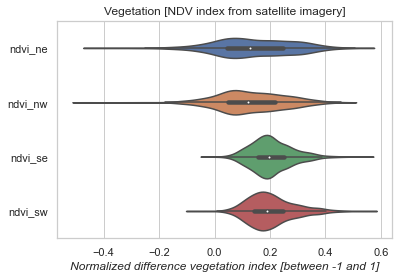

In [38]:
# Satellite vegetation - Normalized difference vegetation index
ax = sns.violinplot(data=features_train[['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw']],
                    orient="h")
ax.set_title("Vegetation [NDV index from satellite imagery]")
ax.set_xlabel("Normalized difference vegetation index [between -1 and 1]", fontstyle="italic")

### All columns

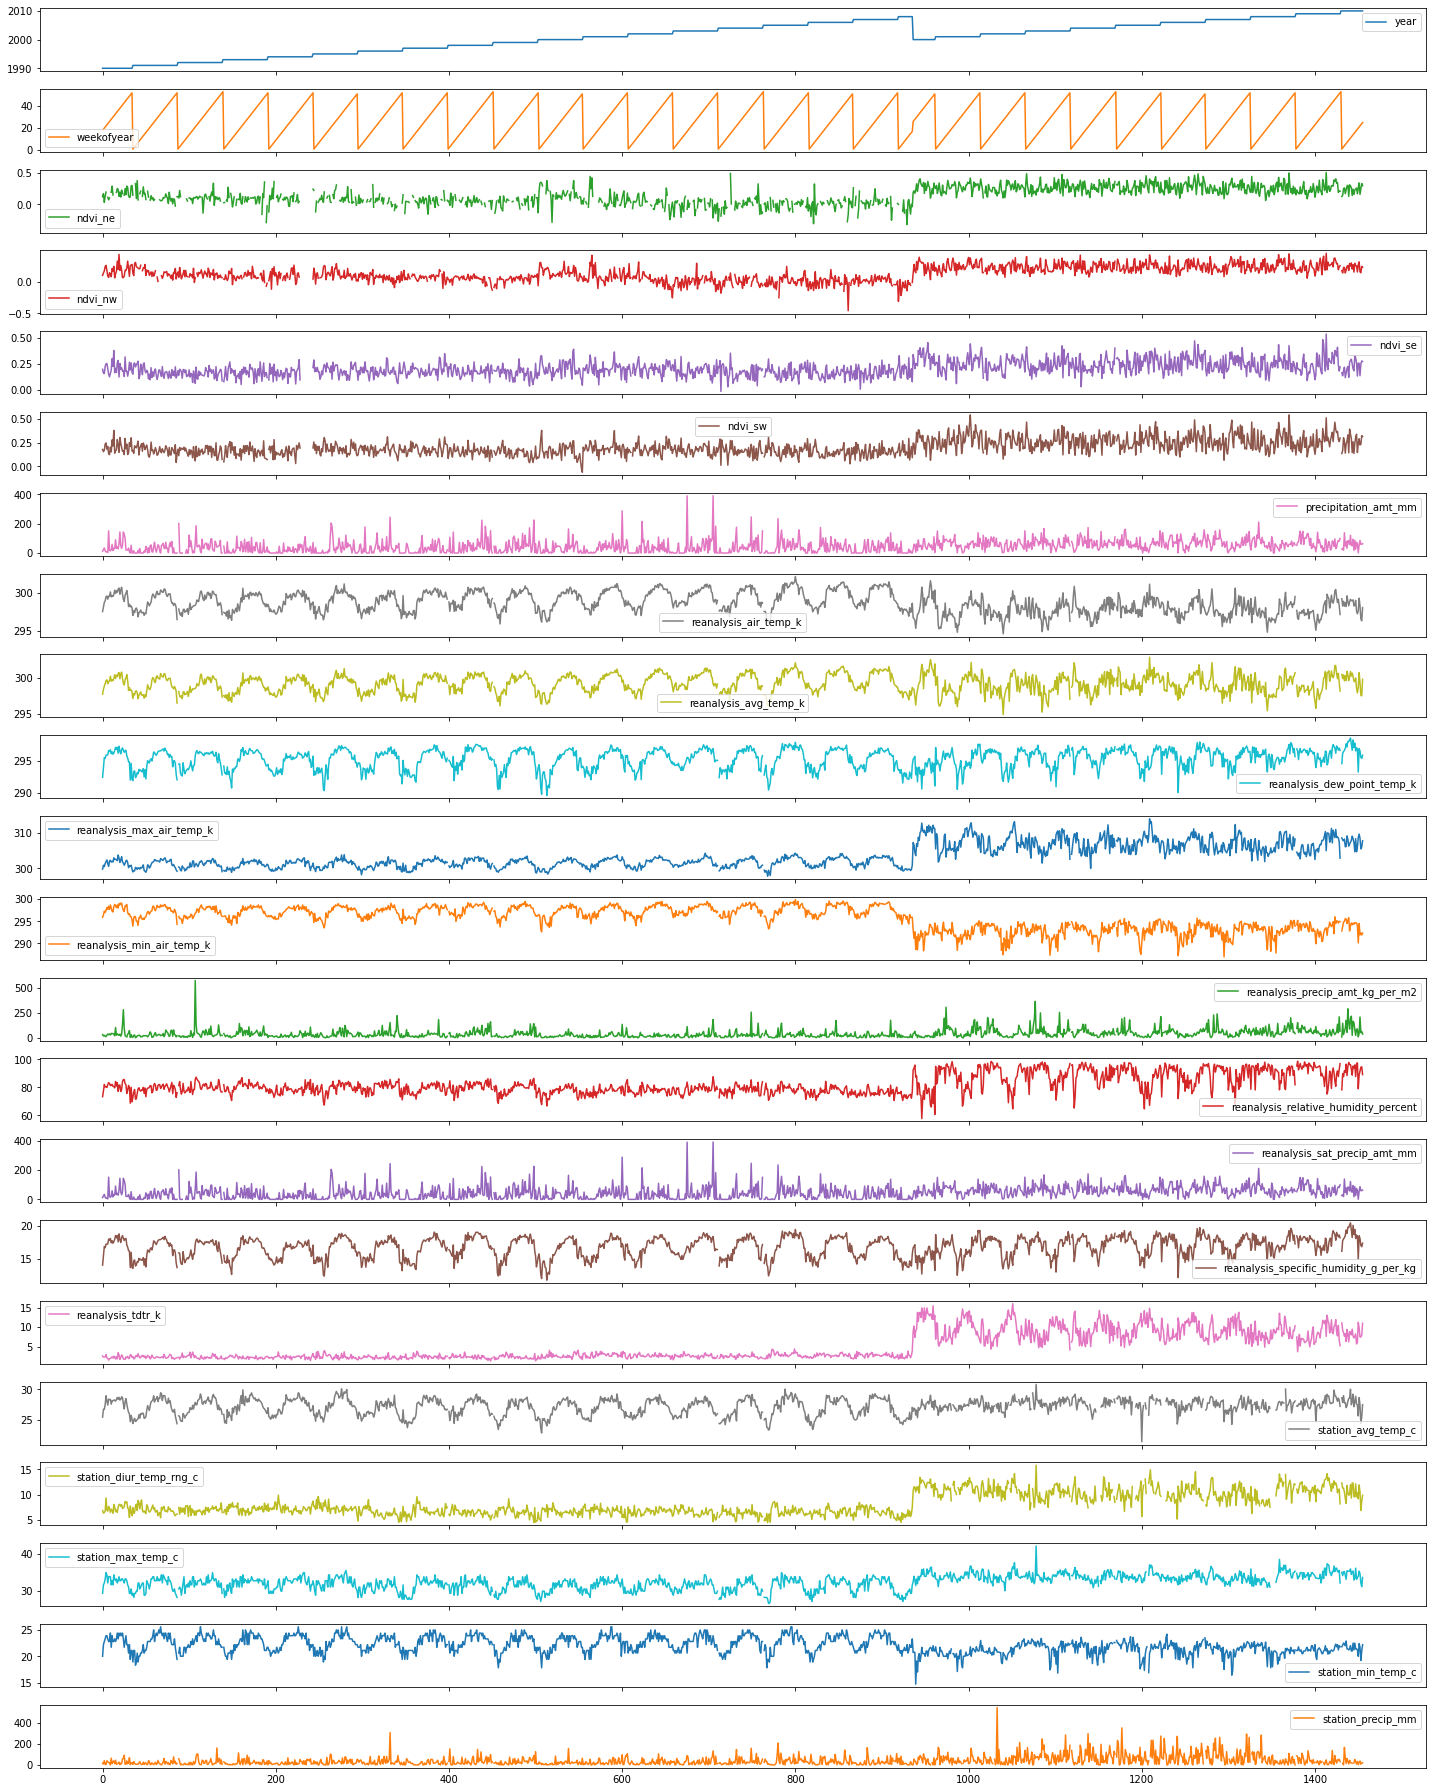

In [9]:
features_train.plot(subplots=True, figsize=(20, 25))

plt.tight_layout()

## Missing values

NaN values in feature data


Text(0.5, 0, 'Number of NaN values')

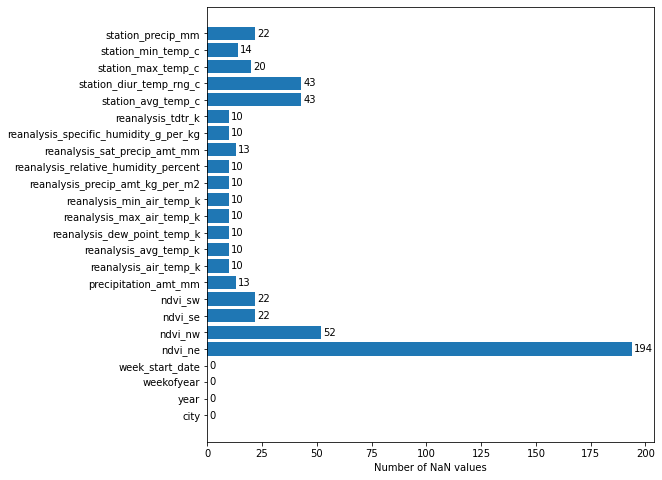

In [165]:
print("NaN values in feature data")

plt.figure(figsize=(8, 8))
fig = plt.barh(y=range(len(features_train.columns)), width=features_train.isna().sum(axis="rows"), tick_label=features_train.columns)
plt.bar_label(fig, padding=2)
plt.xlabel("Number of NaN values")

In [106]:
print("NaN values in labels")
labels_train.isna().sum()

NaN values in labels


city           0
year           0
weekofyear     0
total_cases    0
dtype: int64

Text(0.5, 1.0, 'Weekofyear analysis')

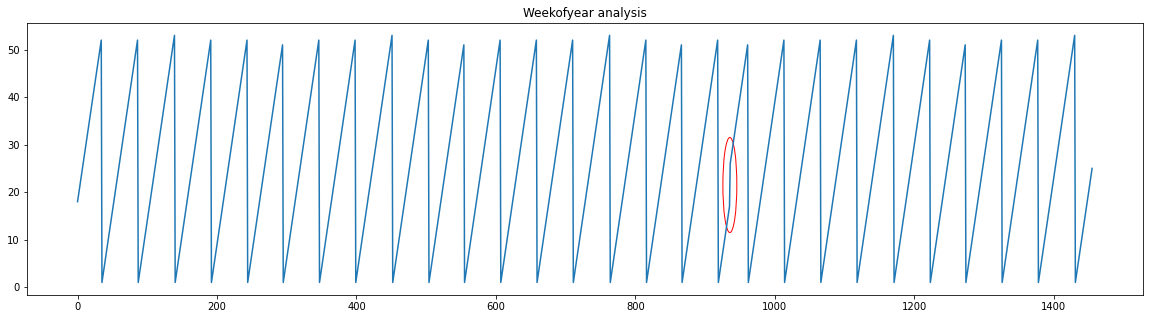

In [100]:
# Verify that there are no weeks of data missing
fig, ax = plt.subplots()
features_train["weekofyear"].plot(figsize=(20,5), ax=ax)

# Highlight change from SJ to IQ
highlight = plt.Circle(xy=(935.5, 21.5), radius=10, color="red", fill=False)
ax.add_artist(highlight)

ax.set_title("Weekofyear analysis for missing data")

## Fourier analysis (seasonality)

Text(0.5, 1.0, 'Fourier analysis for Iquitos and San Juan Dengue Fever Cases')

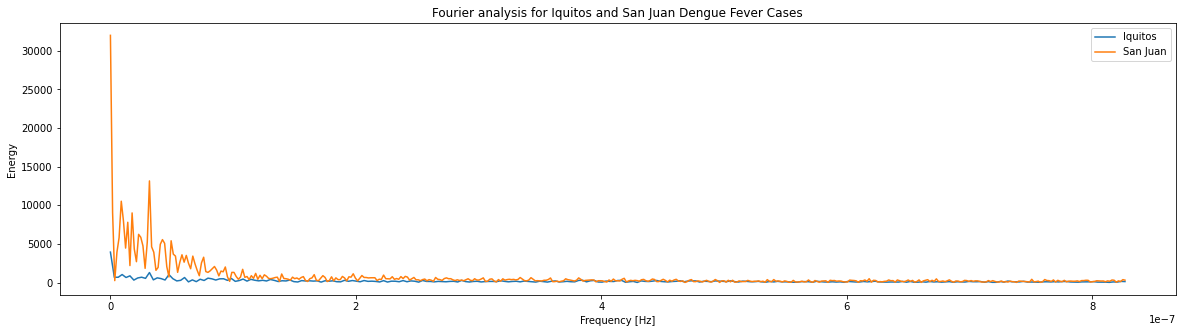

In [90]:
# Fourier analysis to uncover seasonality
SAMPLE_RATE = 1 / (60*60*24*7)  # data sampled once per week

# Fourier transform
yf_iquitos = np.abs(rfft(y_iquitos.to_numpy()))
yf_san_juan = np.abs(rfft(y_san_juan.to_numpy()))

# Frequency information
xf_iquitos = rfftfreq(len(y_iquitos), 1/SAMPLE_RATE)
xf_san_juan = rfftfreq(len(y_san_juan), 1/SAMPLE_RATE)

# Plot
plt.figure(figsize=(20, 5))

plt.plot(xf_iquitos, yf_iquitos, label="Iquitos")
plt.plot(xf_san_juan, yf_san_juan, label="San Juan")

plt.xlabel("Frequency [Hz]")
plt.ylabel("Energy")
plt.legend()
plt.title(f"Fourier analysis for Iquitos and San Juan Dengue Fever Cases")

### Top frequencies

Top 5 frequencies (highest energy):

Iquitos
                    energy  repetition [days]
frequency                                   
0.000000e+00  3934.000000                inf
3.179691e-08  1290.546143         364.000000
9.539072e-09  1031.246948        1213.333374
4.769536e-08  1022.418457         242.666672
1.589845e-08   860.812683         728.000000


San Juan
                     energy  repetition [days]
frequency                                    
0.000000e+00  31993.000000                inf
3.179691e-08  13151.448242         364.000000
8.832474e-09  10521.458008        1310.400024
1.766495e-09   9070.603516        6552.000000
1.766495e-08   9007.288086         655.200012


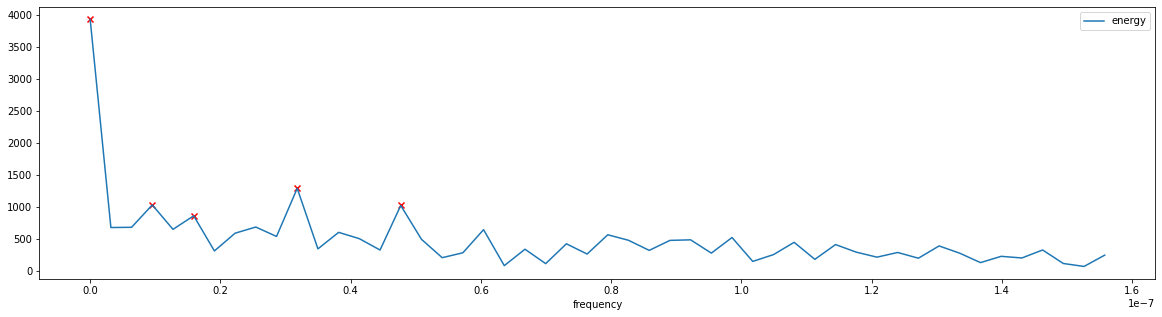

In [91]:
fft_results_iquitos = pd.concat([pd.Series(xf_iquitos), pd.Series(yf_iquitos)], axis=1)
fft_results_iquitos.columns = ["frequency", "energy"]
fft_results_san_juan = pd.concat([pd.Series(xf_san_juan), pd.Series(yf_san_juan)], axis=1)
fft_results_san_juan.columns = ["frequency", "energy"]

# Add repetition (days)
fft_results_iquitos["repetition [days]"] = (1 / fft_results_iquitos["frequency"]) / (60*60*24)
fft_results_iquitos = fft_results_iquitos.astype("float32")
fft_results_san_juan["repetition [days]"] = (1 / fft_results_san_juan["frequency"]) / (60*60*24)
fft_results_san_juan = fft_results_san_juan.astype("float32")

# Get top frequencies
N = 5
print(f"Top {N} frequencies (highest energy):")
top_frequencies_iquitos = fft_results_iquitos.groupby("frequency").max().sort_values("energy", ascending=False).head(N)
print("\nIquitos\n", top_frequencies_iquitos)
top_frequencies_san_juan = fft_results_san_juan.groupby("frequency").max().sort_values("energy", ascending=False).head(N)
print("\n\nSan Juan\n", top_frequencies_san_juan)

# Plot Iquitos top frequencies
fft_results_iquitos[:50].plot(x="frequency", y="energy", figsize=(20, 5))   # Zoom in to interesting frequencies
plt.scatter(x=top_frequencies_iquitos.index, y=top_frequencies_iquitos["energy"], marker="x", c="red")  # Highlight top frequencies

# 3) Data Preparation

In [3]:
# Drop bad predictors
X_train = features_train.drop(["year", "weekofyear", "week_start_date"], axis="columns")
# TODO drop city??

column_names = X_train.columns

# Encode 'city'
X_train["city"] = X_train["city"].apply(lambda x: 0 if (x == "sj") else 1)

# Treat NaN
X_train.fillna(method="ffill", inplace=True)

# Scale for LSTM (see https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)

# Re-cast to Dataframe
X_train = pd.DataFrame(X_train, columns=column_names)

# Get labels only (for convenience)
y_train = labels_train["total_cases"]

X_train.head()

,city,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,0.0,0.578226,0.614835,0.386418,0.395544,0.031797,0.388291,0.354667,0.314680,0.123457,...,0.056091,0.381614,0.031797,0.262659,0.086660,0.430091,0.210393,0.174194,0.486239,0.029450
1,0.0,0.629943,0.657063,0.321190,0.359233,0.058423,0.472710,0.441778,0.489213,0.191358,...,0.031446,0.479668,0.058423,0.418164,0.069133,0.565350,0.163498,0.322581,0.688073,0.015829
2,0.0,0.479441,0.690881,0.311879,0.384430,0.088428,0.548064,0.496000,0.657583,0.166667,...,0.045749,0.594415,0.088428,0.586900,0.064265,0.565350,0.173638,0.354839,0.743119,0.076201
3,0.0,0.584823,0.770066,0.438912,0.491150,0.039324,0.575260,0.539556,0.643471,0.222222,...,0.024365,0.552387,0.039324,0.566808,0.073028,0.645897,0.198986,0.425806,0.788991,0.007362
4,0.0,0.658698,0.788882,0.481601,0.509943,0.019252,0.645515,0.593778,0.701541,0.253086,...,0.021385,0.555396,0.019252,0.628226,0.112950,0.802432,0.429658,0.535484,0.844037,0.010676


# 4) Modelling

## OLS regression

In [93]:
# OLS regression
X_with_intercept = sm.add_constant(X_train)
lin_reg = sm.OLS(y_train, X_with_intercept)
lin_reg_results = lin_reg.fit()
print(lin_reg_results.summary())

                            OLS Regression Results                            
Dep. Variable:            total_cases   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     13.21
Date:                Wed, 26 May 2021   Prob (F-statistic):           1.78e-40
Time:                        15:42:00   Log-Likelihood:                -7438.8
No. Observations:                1456   AIC:                         1.492e+04
Df Residuals:                    1435   BIC:                         1.503e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

## Neural Network

In [93]:
# Reshape inputs for LSTM
look_back = 1

# Add col for t-1 values
X_train["cases_t-1"] = y_train.shift(look_back).fillna(0)
X_train = np.reshape(X_train.to_numpy(), (X_train.shape[0], 1, X_train.shape[1]))

print("Reshaped.")

Reshaped.


In [94]:
no_cols = X_train.shape[1]

learning_rate_vals = []
for i in range(2, 5):
    learning_rate_vals.append(round(6 * 10**(-i), 4))
    learning_rate_vals.append(round(3 * 10**(-i), 4))
    learning_rate_vals.append(round(1 * 10**(-i), 4))

def build_model(hp):
    inputs = tf.keras.Input(shape=(1, X_train.shape[2]))
    hidden1 = layers.LSTM(30)(inputs)
    hidden2 = layers.Dense(30, activation='relu')(hidden1)
    hidden3 = layers.Dense(30, activation='relu')(hidden2)
    hidden4 = layers.Dense(10, activation='relu')(hidden3)
    output = layers.Dense(1)(hidden4)
    model = tf.keras.Model(inputs=inputs, outputs=output)
    model.compile(loss="mean_absolute_error",
                  optimizer=tf.keras.optimizers.Adam(
                      hp.Choice("learning_rate",
                                values=learning_rate_vals))
                  )

    return model

print("Model set up.")

Model set up.


### Hyperparameter tuning

In [103]:
class CustomTuner(kerastuner.tuners.BayesianOptimization):
    """To tune epochs and batch_size. Idea from https://kegui.medium.com/how-to-tune-the-number-of-epochs-and-batch-size-in-keras-tuner-c2ab2d40878d"""
    def run_trial(self, trial, *args, **kwargs):
        kwargs["batch_size"] = trial.hyperparameters.Int("batch_size", 8, 64, step=8)
        kwargs["epochs"] = trial.hyperparameters.Int("epochs", 80, 100, step=10)
        super().run_trial(trial, *args, **kwargs)


tuner = CustomTuner(
    build_model,
    seed=SEED,
    objective='loss',
    max_trials=70,
    executions_per_trial=1
)
tuner.search(X_train, y_train)  # Early stopping

tuner.results_summary()

models = tuner.get_best_models(10)
best_model = models[0]

print("\n\n\nBest model:")
print(best_model.summary())
print("\nHyperparameters chosen:")
print(tuner.get_best_hyperparameters()[0].values)

INFO:tensorflow:Reloading Oracle from existing project .\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json
INFO:tensorflow:Oracle triggered exit
Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name='loss', direction='min')
Trial summary
Hyperparameters:
learning_rate: 0.0006
batch_size: 48
epochs: 90
Score: 6.216445446014404
Trial summary
Hyperparameters:
learning_rate: 0.0006
batch_size: 40
epochs: 90
Score: 6.221660137176514
Trial summary
Hyperparameters:
learning_rate: 0.0006
batch_size: 40
epochs: 90
Score: 6.229079723358154
Trial summary
Hyperparameters:
learning_rate: 0.001
batch_size: 40
epochs: 90
Score: 6.230096340179443
Trial summary
Hyperparameters:
learning_rate: 0.0006
batch_size: 32
epochs: 90
Score: 6.236622333526611
Trial summary
Hyperparameters:
learning_rate: 0.0006
batch_size: 40
epochs: 90
Score: 6.237322807312012
Trial summary
Hyperparameters:
learning_rate: 0.0006
batch_size: 40
epochs: 

# 5) Evaluation

NN MAE = 6.2041521760440625
OLS MAE = 21.429071188282617


<AxesSubplot:xlabel='date'>

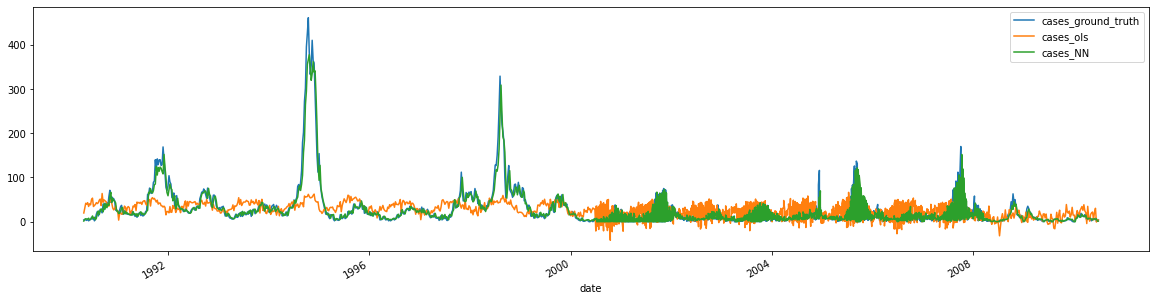

In [110]:
from sklearn.metrics import mean_absolute_error

train_datetime_index = pd.to_datetime(features_train["week_start_date"])

nn_predicts = best_model.predict(X_train)
nn_predicts = pd.DataFrame(nn_predicts).iloc[:, 0]
lin_reg_predicts = lin_reg.predict(lin_reg_results.params)
lin_reg_predicts = pd.Series(lin_reg_predicts)

print(f"NN MAE = {mean_absolute_error(y_train, nn_predicts)}")
print(f"OLS MAE = {mean_absolute_error(y_train, lin_reg_predicts)}")

ground_truth = pd.concat([train_datetime_index, y_train, lin_reg_predicts, nn_predicts], axis=1, ignore_index=True)
ground_truth.columns = ["date", "cases_ground_truth", "cases_ols", "cases_NN"]
ground_truth.plot(x="date", y=["cases_ground_truth", "cases_ols", "cases_NN"], figsize=(20, 5))